In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.models import load_model
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras
import math
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline

C:\Users\tbrti\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [3]:
data = pd.read_pickle(r'C:\Users\tbrti\Desktop\Nani\PACEDS\Course_Project\Data\Final_df.pkl')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data['Y'] = data.lrets.shift(-1)
data.dropna(axis=0, inplace=True)
data.head()

,Adj Close,Volume,lrets,MACD,stochastics,ATR,neg,neu,pos,Y
1990-02-01,328.790009,154580000.0,-0.000882,-2.527546,32.695563,2.099975,0.073,0.870,0.057,0.006457
1990-02-02,330.920013,164400000.0,0.006457,-1.897056,44.682087,4.010010,0.067,0.858,0.075,0.002806
1990-02-05,331.850006,130950000.0,0.002806,-1.290922,54.854696,1.709992,0.106,0.815,0.080,-0.006621
1990-02-06,329.660004,134070000.0,-0.006621,-0.943830,41.311070,3.659973,0.062,0.891,0.047,0.012330
1990-02-07,333.750000,186710000.0,0.012330,-0.338525,66.604826,7.210022,0.035,0.920,0.045,-0.002370


In [4]:
data.shape

(6427, 10)

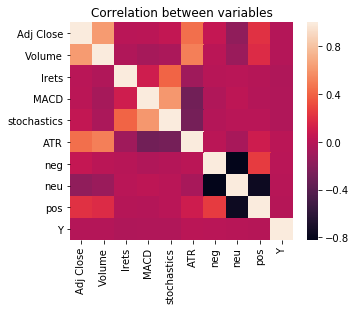

In [5]:
corr = data.corr()
f, ax = plt.subplots(figsize=(5, 4))
plt.title("Correlation between variables")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [6]:
def load_data(stock, seq_len, split):
    amount_of_features = len(stock.columns)
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    # This will cause data leakge problem
    scaler = RobustScaler()
    data = scaler.fit_transform(data)
    
    for index in range(len(data) - sequence_length): # row - seq_len
        result.append(data[index: index + sequence_length]) # result.append(day i to day i + 22)  
    
    result = np.array(result)
    
    row = round(split * result.shape[0])
    train = result[:int(row), :]
    X_train = train[:, :, :-1] 
    y_train = train[:, :, -1][:, -1]
    
    X_test = result[int(row):, :, :-1]
    y_test = result[int(row):, :, -1][:, -1]
    
   # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
   # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [7]:
amount_of_features = len(data.columns)
seq_len= 21
split = 0.8
layers = [seq_len, 10]
d = 0.2 # Fraction of the input units to drop
epochs = 100

In [8]:
X_train, y_train, X_test, y_test = load_data(data, seq_len, split)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5124, 22, 9), (5124,), (1281, 22, 9), (1281,))

In [10]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

callbacks_list = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0.00001, verbose=1)]

In [11]:
def build_model(layers, d):
        model = Sequential()
        
        model.add(GRU(2048, input_shape=(layers[0]+1, layers[1]-1), return_sequences=True))
        model.add(GRU(1024, return_sequences=True))
        model.add(GRU(512, return_sequences=False))       
        
        model.add(Dense(256, activation='relu'))#,kernel_regularizer=regularizers.l2()))
        model.add(Dropout(d))
        model.add(BatchNormalization())
        
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        model.compile(loss='mse',optimizer='adam',metrics=[r2_keras])
        return model

In [12]:
model = build_model([seq_len, amount_of_features], d)

In [13]:
model.fit(
    X_train,
    y_train,
    batch_size=512, # Using mini-batch gradient descent
    epochs=epochs, # Doesn't matter because we are using early stopping
    validation_split=0.1,
    verbose=1,
    callbacks = callbacks_list)

Train on 4611 samples, validate on 513 samples
Epoch 1/100
4611/4611 [==============================] - 737s 160ms/step - loss: 2.4863 - r2_keras: -0.9973 - val_loss: 1.9872 - val_r2_keras: -7053.7211
Epoch 2/100
4611/4611 [==============================] - 712s 154ms/step - loss: 1.5035 - r2_keras: -0.1806 - val_loss: 2.2633 - val_r2_keras: -24223.6987
Epoch 3/100
4611/4611 [==============================] - 1215s 263ms/step - loss: 1.4928 - r2_keras: -0.1665 - val_loss: 2.0713 - val_r2_keras: -1144.1787
Epoch 4/100
4611/4611 [==============================] - 665s 144ms/step - loss: 1.4571 - r2_keras: -0.1393 - val_loss: 1.4462 - val_r2_keras: -54.1797
Epoch 5/100
4611/4611 [==============================] - 722s 157ms/step - loss: 1.4429 - r2_keras: -0.1276 - val_loss: 1.7134 - val_r2_keras: -211.1524
Epoch 6/100
4611/4611 [==============================] - 722s 157ms/step - loss: 1.5335 - r2_keras: -0.2075 - val_loss: 1.4708 - val_r2_keras: -0.7487
Epoch 7/100
4611/4611 [==========

In [14]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('RMSE: %2f' % math.sqrt(trainScore[0]), 'R2 : %2f' % trainScore[1])

testScore = model.evaluate(X_test, y_test, verbose=0)
print('RMSE: %2f'% math.sqrt(testScore[0]), 'R2 : %2f' % testScore[1])

RMSE: 1.449454 R2 : -1.663051
RMSE: 0.941537 R2 : -15000.318549


In [15]:
p = model.predict(X_test)

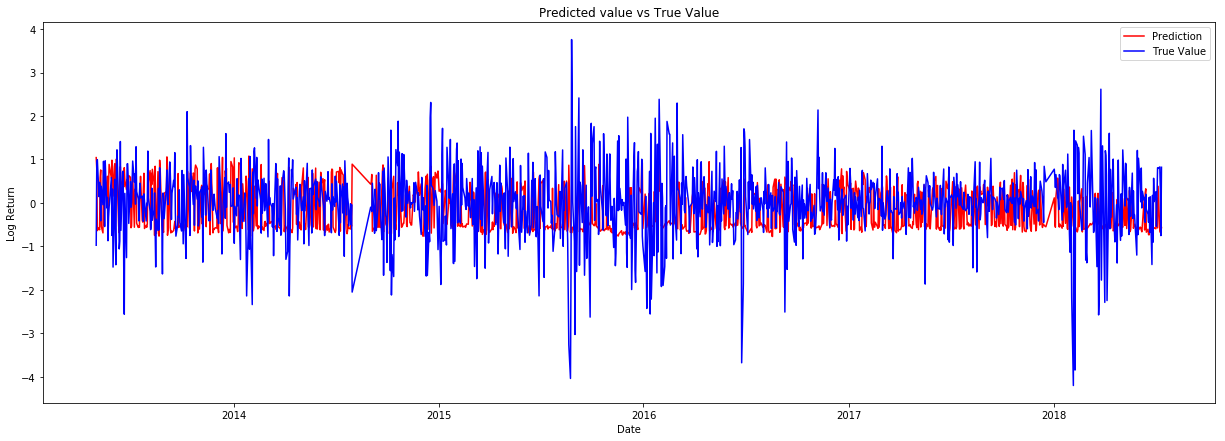

In [16]:
plt.figure(figsize=(21,7))
plt.plot(data.index[-len(p):], p,color='red', label='Prediction')
plt.plot(data.index[-len(y_test):], y_test,color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()

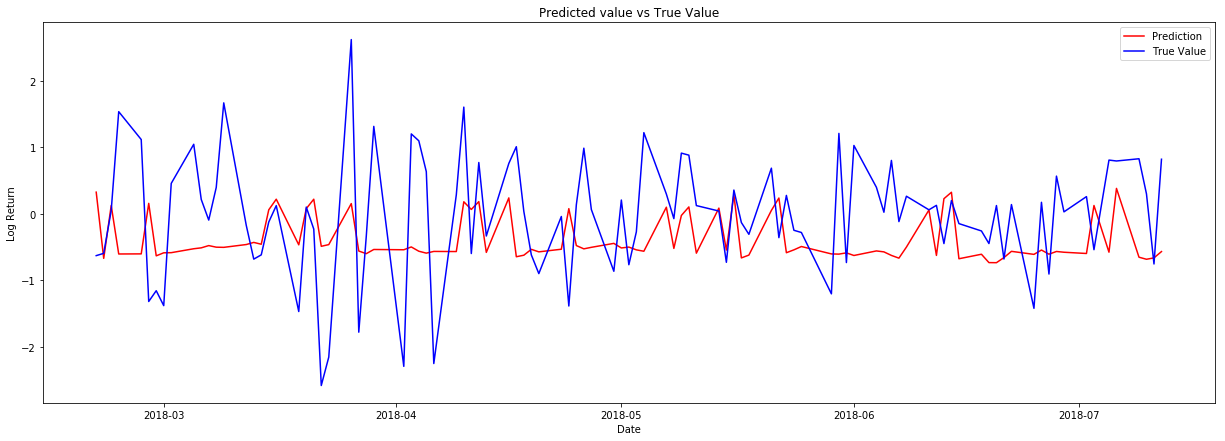

In [20]:
plt.figure(figsize=(21,7))
plt.plot(data.index[-100:], p[-100:], color='red', label='Prediction')
plt.plot(data.index[-100:], y_test[-100:], color='blue', label='True Value')
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.title('Predicted value vs True Value')
plt.legend(loc='best')
plt.show()